In [45]:
# Import necessary libraries
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.metrics import confusion_matrix
from tensorflow import keras

from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, clone_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models


In [46]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices thru One-hot Encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


In [47]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

print(x_train.dtype)
print(x_train.ndim)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
float32
4


In [48]:
from keras.backend import clear_session
clear_session()

In [49]:
# DEFINE the Model

input_shape = (32, 32, 3)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu",),
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu",),        
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),    
        layers.BatchNormalization(),                                      # BatchNorm after Conv layer """
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),  # Added Extra layer
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),  # Added Extra layer        
        layers.BatchNormalization(),                                      # BatchNorm after Conv layer
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding='same'),  # Added Extra layer
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding='same'),  # Added Extra layer
        layers.BatchNormalization(),                                      # BatchNorm after Conv layer """
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),                                      # BatchNorm after Conv layer
        layers.Dense(10, activation="softmax"),
    ]
)

In [50]:
# COMPILE the Model

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

In [51]:
# DATA AUGMENTATION TO INCREASE THE TRAINING DATA BY APPLYING RANDOM TRANSFORMATION (like rotation, zooming)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # Rotate images up to 15 degrees
    width_shift_range=0.1,   # Horizontally shift images by 10%
    height_shift_range=0.1,  # Vertically shift images by 10%
    horizontal_flip=True,    # Randomly flip images
)

# Fit the data generator on the training data
datagen.fit(x_train)

# Using the data generator when training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(x_test, y_test))

#history = model.fit(x_train, y_train, batch_size=64, epochs=50)


Epoch 1/50
782/782 [==============================] - 7s 6ms/step - loss: 1.3613 - accuracy: 0.5142
Epoch 2/50
782/782 [==============================] - 5s 6ms/step - loss: 0.8509 - accuracy: 0.7003
Epoch 3/50
782/782 [==============================] - 5s 6ms/step - loss: 0.6711 - accuracy: 0.7678
Epoch 4/50
782/782 [==============================] - 5s 6ms/step - loss: 0.5545 - accuracy: 0.8090
Epoch 5/50
782/782 [==============================] - 5s 6ms/step - loss: 0.4660 - accuracy: 0.8376
Epoch 6/50
782/782 [==============================] - 5s 6ms/step - loss: 0.3905 - accuracy: 0.8650
Epoch 7/50
782/782 [==============================] - 5s 6ms/step - loss: 0.3381 - accuracy: 0.8823
Epoch 8/50
782/782 [==============================] - 5s 6ms/step - loss: 0.2780 - accuracy: 0.9022
Epoch 9/50
782/782 [==============================] - 5s 6ms/step - loss: 0.2378 - accuracy: 0.9174
Epoch 10/50
782/782 [==============================] - 5s 6ms/step - loss: 0.1994 - accuracy: 0.9302

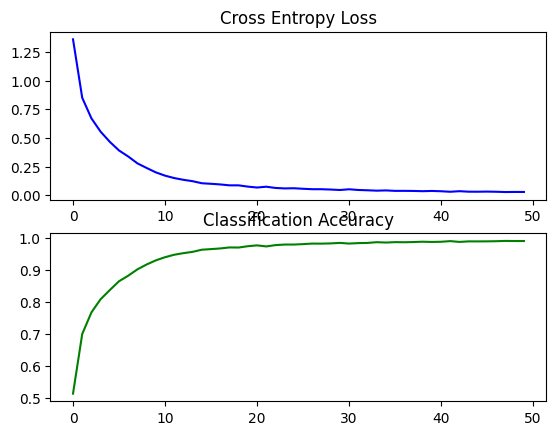

313/313 [==============================] - 1s 2ms/step - loss: 0.7684 - accuracy: 0.8530
Model Loss: 0.7684003710746765
Model Accuracy: 0.8529999852180481
313/313 [==============================] - 1s 1ms/step


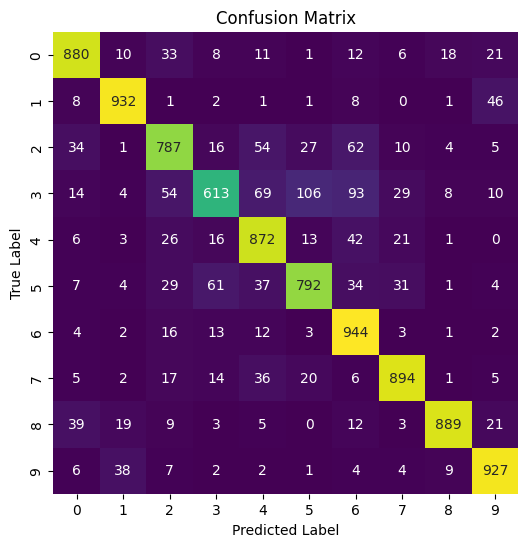

In [52]:

def evaluate_model(model, history):
    
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='val')

    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='green', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='val')
    plt.show()

    # evaluate model
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Model Loss:', test_loss)
    print('Model Accuracy:', test_acc)

    # make predictions
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    conf_mat = confusion_matrix(y_test_labels, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    
evaluate_model(model,history)

In [53]:
""" # Predicting the output for the test split
y_pred = model.predict(x_test)

# use argmax function to findout which class has the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)  # 10 classes of possible images
y_true_classes = np.argmax(y_test, axis=1)  # actual class

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_vgg_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Deeper Model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show() """

" # Predicting the output for the test split\ny_pred = model.predict(x_test)\n\n# use argmax function to findout which class has the highest probability\ny_pred_classes = np.argmax(y_pred, axis=1)  # 10 classes of possible images\ny_true_classes = np.argmax(y_test, axis=1)  # actual class\n\n# Generate the confusion matrix\nconf_matrix = confusion_matrix(y_true_classes, y_pred_vgg_classes)\n\n# Plot the confusion matrix using seaborn\nplt.figure(figsize=(8,6))\nsns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)\nplt.title('Confusion Matrix for Deeper Model')\nplt.xlabel('Predicted Class')\nplt.ylabel('True Class')\nplt.show() "

In [54]:
# Evaluate the model with test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.7684 - accuracy: 0.8530


In [55]:
""" 
# Initialize the VGG16 model, pre-trained on ImageNet, without the top classification layer

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Extract features for the training and test sets
train_features = vgg16_model.predict(x_train)
test_features = vgg16_model.predict(x_test)

# Reshape the extracted features
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

# Now the extracted features (train_features and test_features) can be used for further processing
print('Train features shape:', train_features.shape)
print('Test features shape:', test_features.shape) """


" \n# Initialize the VGG16 model, pre-trained on ImageNet, without the top classification layer\n\nvgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))\n\n# Extract features for the training and test sets\ntrain_features = vgg16_model.predict(x_train)\ntest_features = vgg16_model.predict(x_test)\n\n# Reshape the extracted features\ntrain_features = train_features.reshape(train_features.shape[0], -1)\ntest_features = test_features.reshape(test_features.shape[0], -1)\n\n# Now the extracted features (train_features and test_features) can be used for further processing\nprint('Train features shape:', train_features.shape)\nprint('Test features shape:', test_features.shape) "